# <center> Random Forest & Gradient Boosting Decision Tree on Amazon Fine Food Reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Split data into train and test using time based slicing as 70%  train & 30% test.
3.	Perform featurization BoW,TFIDF, Avg Word2Vec, tf-idf-Word2Vec.
4.	Apply GridsearchCV on train data to find optimal hyperparameters for both GBDT and RF.
5.	Apply GBDT(Gradient Boosting Decision Tree) and RF(Random Forest)  on dataset.
6.	To test the performance of the model, calculate test error, train error, accuracy,precision,recall,F1-score,confusion matrix(TPR,TNR,FPR,FNR)
7.  Write your observations in English as crisply and unambiguously as possible. Always quantify your results.



### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform(BoW,TF-IDF,Avg Word2ec and TFIDF Word2Vec) and apply ensemble models like bagging and boosting to evaluate whether a review is positive or negative.<span>

---


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import traceback
import sqlite3
import itertools
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from prettytable import PrettyTable
from sklearn import preprocessing
from sklearn.externals import joblib
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### (1) Load dataset :

Dataset Shape : 
 (150000, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    127267
negative     22733
Name: Score, dtype: int64



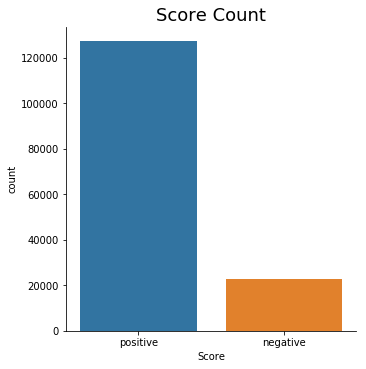

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
250,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
383,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
369,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19 05:30:00,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
268,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26 05:30:00,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
350,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03 05:30:00,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...


In [3]:
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# For Data Cleaning Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=1JXCva5vXdIPgHbfNdD9sgnySqELoVtpy
# dataset - https://drive.google.com/open?id=1IoDoTT8TfDu53N6cyKg6xVCU-FDPHyIF

# For Text Preporcessing Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=18-AkTzzEhCwM_hflIbDNBMAP-imX4k4i
# dataset - https://drive.google.com/open?id=1SfDwwXFhDpjgtfIE5O_E80SO89xRc8Sa

# Load dataset
def load_review_dataset():
    # Create connection object to load sqlite dataset
    connection = sqlite3.connect('finalDataSet.sqlite')

    # Load data into pandas dataframe.
    reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
    reviews_df = reviews_df.drop(columns=['index'])
    
   
    # Take sample of 150K reviews, to reduce training time.     
    reviews_df = reviews_df.sample(150000)
        
    # Convert timestamp to datetime.
    reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

    # Sort the data on the basis of time.
    reviews_df = reviews_df.sort_values(by=['Time'])

    print("Dataset Shape : \n",reviews_df.shape)
    print("\nColumn Names: \n",reviews_df.columns)
    print("\nTarget Class label : ")
    print(reviews_df['Score'].value_counts())
    print()   
    
    return reviews_df


# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset()

# Split data into train and test
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(reviews_df['CleanedText'].values,
                                                    reviews_df['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False,
                                                    random_state=0)

# Plot score
sns.catplot(x ="Score",kind='count',data=reviews_df,height=5)
plt.title("Score Count", fontsize=18)
plt.show()
reviews_df.head()

In [4]:
###--- All utility variables and functions(After importing all the necessary packages, always run this cell first.) ---###

# Hyperparameter list_n_estimators
list_n_estimators = []

# Training Error
train_error = []

# Test Error
test_error = []


def plot_report_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):    
    plt.figure()
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    TN = confusion_matrix[0,0]       
    FP = confusion_matrix[0,1]  
    FN = confusion_matrix[1,0]
    TP = confusion_matrix[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))","{0:.2f}".format(TPR)])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))","{0:.2f}".format(TNR)])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))","{0:.2f}".format(FPR)])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))","{0:.2f}".format(FNR)])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))","{0:.2f}%".format(ACC*100)])
    
    # Print pretty table values
    print(ptable)


def performance_measure(classifier,train_feature,test_feature):
    print("-------------------------- {0} --------------------------".format(type(classifier).__name__))           
            
    # Predict target class label
    predicted_y_test = classifier.predict(test_feature)
    
    # Predict train class label
    predicted_y_train = classifier.predict(train_feature)
            
    ptable = PrettyTable()
    ptable.title = "GridSearchCV"                    
    ptable.field_names = ["Hyperparameter (n_estimators)","Scoring","Mean","Variance"]

    list_means = classifier.cv_results_['mean_test_score']
    list_stds = classifier.cv_results_['std_test_score']
    list_params = classifier.cv_results_['params']   
       
    for mean, std, params in zip(list_means, list_stds, list_params):                
        ptable.add_row([params['n_estimators'],"Accuracy", "{0:.2f}".format(mean), "{0:.2f}".format(std*2)])

               
    print()
    print(ptable)
    print()

    optimal_n_estimators = classifier.best_params_['n_estimators']   
    train_accuracy = accuracy_score(Y_TRAIN, predicted_y_train)
    test_accuracy = accuracy_score(Y_TEST, predicted_y_test)
    
    list_n_estimators.append(optimal_n_estimators)    
    
    test_error.append(1 - test_accuracy)
    train_error.append(1 - train_accuracy)    
             
    # Print Optimal hyperparameter and corresponding accuracy
    ptable = PrettyTable()
    ptable.title = "Optimal hyperparameter & Testing accuracy score"
    ptable.field_names=["Cross Validation","Optimal Hyperparameter (n_estimators)","Accuracy(%)"]
    ptable.add_row([type(classifier).__name__ ,optimal_n_estimators,"{0:.2f}".format(classifier.best_score_*100)])
    print(ptable)  
            
    # Print classification report
    print()          
    ptable = PrettyTable()
    ptable.title = "Classification Report with n_estimator = {0}".format(optimal_n_estimators)
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,
                        "{0:.2f}".format(inner_dict['precision']),
                        "{0:.2f}".format(inner_dict['recall']),
                        "{0:.2f}".format(inner_dict['f1-score']),
                        "{0:.2f}".format(inner_dict['support'])])
            
    print(ptable)
           
    # Calculate and plot confusion matrix
    cnf_mat = confusion_matrix(Y_TEST, predicted_y_test)            
    plot_report_confusion_matrix(cnf_mat, classes=["negative", "positive"],title='Confusion Matrix')
    print()        
    print()
    
    
def conclude_RF():
    ptable=PrettyTable()
    ptable.title = "*** Conclusion - Random Forest ***"
    ptable.field_names=["CV","Model","Hyperparameter 'n_estimators'","Train Error","Test Error"]
    ptable.add_row(["GridSearchCV",
                    "BOW:RF",
                    list_n_estimators[0],                
                    str(round(train_error[0], 2)*100)+"%",
                    str(round(test_error[0], 2)*100)+"%"])
                
    ptable.add_row(["GridSearchCV",
                    "TFIDF:RF",
                    list_n_estimators[1],                    
                    str(round(train_error[1], 2)*100)+"%",
                    str(round(test_error[1], 2)*100)+"%"])

    ptable.add_row(["GridSearchCV",
                    "AVG-WORD2VEC:RF",
                    list_n_estimators[2],                    
                    str(round(train_error[2], 2)*100)+"%",
                    str(round(test_error[2], 2)*100)+"%"])
                        
    ptable.add_row(["GridSearchCV",
                    "TFIDF-WORD2VEC:RF",
                    list_n_estimators[3],                    
                    str(round(train_error[3], 2)*100)+"%",
                    str(round(test_error[3], 2)*100)+"%"])

    print(ptable)



def conclude_GBDT():
    ptable=PrettyTable()
    ptable.title = "*** Conclusion - GBDT(XGBOOST) ***"
    ptable.field_names=["Model","n_estimators","learning_rate","max_depth","Train ROC-AUC Score","Test ROC-AUC Score"]
    ptable.add_row(["BOW:XGBOOST",
                    list_n_estimators[0],
                    list_learning_rate[0],   
                    list_max_depth[0],   
                    train_roc_auc_score[0],
                    test_roc_auc_score[0]])
                
    ptable.add_row(["TFIDF:XGBOOST",
                    list_n_estimators[1],
                    list_learning_rate[1],   
                    list_max_depth[1],   
                    train_roc_auc_score[1],
                    test_roc_auc_score[1]])

    ptable.add_row(["AVG-WORD2VEC:XGBOOST",
                    list_n_estimators[2],
                    list_learning_rate[2],   
                    list_max_depth[2],   
                    train_roc_auc_score[2],
                    test_roc_auc_score[2]])
                        
    ptable.add_row(["TFIDF-WORD2VEC:XGBOOST",
                    list_n_estimators[3],
                    list_learning_rate[3],   
                    list_max_depth[3],   
                    train_roc_auc_score[3],
                    test_roc_auc_score[3]])

    print(ptable)


<br/><br/>

<br/>

###  ------------------- Ensemble Model : Bagging ( Random Forest )  -------------------


In [5]:
# Ideal values of n_estimators-More information http://scikit-learn.org/stable/modules/ensemble.html#parameters
parameters = {'n_estimators':[100,200,300,400,500,600,700,800,900,1000]}

### (2) Convert review text to vector representation :
#### (2.1) Bag of Words (BoW) :

In [6]:
# Instantiate Random Forest
randomForestClassifier = RandomForestClassifier(class_weight="balanced_subsample",n_jobs=-1)
randomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [7]:
%%time

# Instantiate CountVectorizer
bow_count_vectorizer = CountVectorizer()

# Tokenize and build vocab
bow_count_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = bow_count_vectorizer.transform(X_TRAIN)
x_test_matrix = bow_count_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (105000, 46035)
The number of unique words in train matrix  46035
Wall time: 6.52 s


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 72.7min finished


Best Hyperparameter 'n_estimator' :  100
Accuracy on BoW : 86.15%
-------------------------- GridSearchCV --------------------------

+------------------------------------------------------------+
|                        GridSearchCV                        |
+-------------------------------+----------+------+----------+
| Hyperparameter (n_estimators) | Scoring  | Mean | Variance |
+-------------------------------+----------+------+----------+
|              100              | Accuracy | 0.86 |   0.01   |
|              200              | Accuracy | 0.86 |   0.01   |
|              300              | Accuracy | 0.86 |   0.01   |
|              400              | Accuracy | 0.86 |   0.01   |
|              500              | Accuracy | 0.86 |   0.01   |
|              600              | Accuracy | 0.86 |   0.01   |
|              700              | Accuracy | 0.86 |   0.01   |
|              800              | Accuracy | 0.86 |   0.01   |
|              900              | Accuracy | 0.

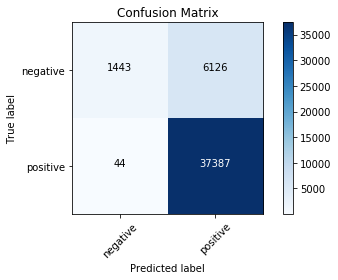


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 37387  |
|           TN (True Negative)           |  1443  |
|          FP (False Positive)           |  6126  |
|          FN (False Negative)           |   44   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  1.00  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.19  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.81  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.00  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 86.29% |
+----------------------------------------+--------+


Wall time: 1h 13min 41s


In [8]:
%%time

# Instantiate Random Forest
randomForestClassifier = RandomForestClassifier(class_weight="balanced_subsample",n_jobs=-1)

# Grid search cross Validation on bow
gscv = GridSearchCV(randomForestClassifier, 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

print("Best Hyperparameter 'n_estimator' : ",gscv.best_params_.get('n_estimators'))
print("Accuracy on BoW : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,x_train_matrix,x_test_matrix)

#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [9]:
# Instantiate Random Forest
randomForestClassifier = RandomForestClassifier(class_weight="balanced_subsample",n_jobs=-1)
randomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [10]:
%%time
# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)
x_test_matrix = tfidf_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (105000, 239302)
The number of unique words in train matrix  239302
Wall time: 18.4 s


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 164.3min finished


Best Hyperparameter 'n_estimators' :  100
Accuracy on TF-IDF : 86.23%
-------------------------- GridSearchCV --------------------------

+------------------------------------------------------------+
|                        GridSearchCV                        |
+-------------------------------+----------+------+----------+
| Hyperparameter (n_estimators) | Scoring  | Mean | Variance |
+-------------------------------+----------+------+----------+
|              100              | Accuracy | 0.86 |   0.01   |
|              200              | Accuracy | 0.86 |   0.01   |
|              300              | Accuracy | 0.86 |   0.01   |
|              400              | Accuracy | 0.86 |   0.01   |
|              500              | Accuracy | 0.86 |   0.01   |
|              600              | Accuracy | 0.86 |   0.01   |
|              700              | Accuracy | 0.86 |   0.01   |
|              800              | Accuracy | 0.86 |   0.01   |
|              900              | Accuracy 

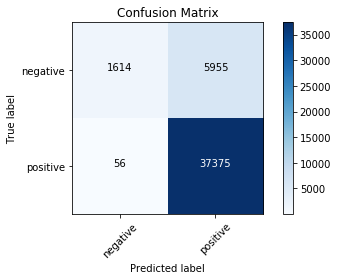


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 37375  |
|           TN (True Negative)           |  1614  |
|          FP (False Positive)           |  5955  |
|          FN (False Negative)           |   56   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  1.00  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.21  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.79  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.00  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 86.64% |
+----------------------------------------+--------+


Wall time: 2h 46min 35s


In [11]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(randomForestClassifier, 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

print("Best Hyperparameter 'n_estimators' : ",gscv.best_params_.get('n_estimators'))
print("Accuracy on TF-IDF : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,x_train_matrix,x_test_matrix)

#### (2.3) Average Word2Vec :

In [12]:
# Instantiate Random Forest
randomForestClassifier = RandomForestClassifier(class_weight="balanced_subsample",n_jobs=-1)
randomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [13]:
%%time

# Create our own Word2Vec model from training data.
        
# Make list of list from training data
list_of_sentences_in_train=[]
for sentence in X_TRAIN:
    list_of_sentences_in_train.append(sentence.split())
            
# Make list of list from testing data - this will be useful when vectorizing testing data.
list_of_sentences_in_test=[]
for sentence in X_TEST:
    list_of_sentences_in_test.append(sentence.split())
            
print("Shape of training data : ",X_TRAIN.shape)
print("Shape of testing data : ",X_TEST.shape)
print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
        
# Generate model
w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=50, workers=6)
        
# List of word in vocabulary 
w2v_words = list(w2v_model.wv.vocab)
print("Length of vocabulary : ",len(w2v_words))

# Prepare train vectorizer using trained word2vec model
train_list = []
for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
    word_2_vec = np.zeros(50)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    train_list.append(word_2_vec)
        
# Prepare test vectorizer using trained word2vec model
test_list = []
for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
    word_2_vec = np.zeros(50)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    test_list.append(word_2_vec)
            
avg_w2v_train = np.array(train_list)
avg_w2v_test = np.array(test_list)
           

print("\nShape of training vectorizer : ",avg_w2v_train.shape)
print("Shape of testing vectorizer : ",avg_w2v_test.shape)

Shape of training data :  (105000,)
Shape of testing data :  (45000,)
Number of sentences present in training data :  105000
Number of sentences present in testing data :  45000
Length of vocabulary :  16602


Average Word2Vec - Test data: 100%|█████████████████████████████████████| 45000/45000 [00:43<00:00, 1034.98 sentence/s]



Shape of training vectorizer :  (105000, 50)
Shape of testing vectorizer :  (45000, 50)
Wall time: 2min 26s


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.4min finished


Best Hyperparameter 'n_estimators' :  100
Accuracy on TF-IDF : 87.24%
-------------------------- GridSearchCV --------------------------

+------------------------------------------------------------+
|                        GridSearchCV                        |
+-------------------------------+----------+------+----------+
| Hyperparameter (n_estimators) | Scoring  | Mean | Variance |
+-------------------------------+----------+------+----------+
|              100              | Accuracy | 0.87 |   0.01   |
|              200              | Accuracy | 0.87 |   0.01   |
|              300              | Accuracy | 0.87 |   0.01   |
|              400              | Accuracy | 0.87 |   0.01   |
|              500              | Accuracy | 0.87 |   0.01   |
|              600              | Accuracy | 0.87 |   0.01   |
|              700              | Accuracy | 0.87 |   0.01   |
|              800              | Accuracy | 0.87 |   0.01   |
|              900              | Accuracy 

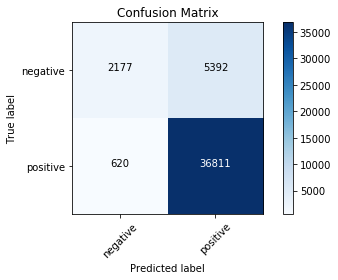


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 36811  |
|           TN (True Negative)           |  2177  |
|          FP (False Positive)           |  5392  |
|          FN (False Negative)           |  620   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.98  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.29  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.71  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.02  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 86.64% |
+----------------------------------------+--------+


Wall time: 14min 40s


In [14]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(randomForestClassifier, 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(avg_w2v_train,Y_TRAIN)

print("Best Hyperparameter 'n_estimators' : ",gscv.best_params_.get('n_estimators'))
print("Accuracy on TF-IDF : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,avg_w2v_train,avg_w2v_test)

#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [15]:
# Instantiate Random Forest
randomForestClassifier = RandomForestClassifier(class_weight="balanced_subsample",n_jobs=-1)
randomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [16]:
%%time

# Make list of list from training data.      
sentences_in_train=[]
for sentence in X_TRAIN:
    sentences_in_train.append(sentence.split())

# Make list of list from testing data - this will be useful when vectorizing testing data.
sentences_in_test=[]
for sentence in X_TEST:
    sentences_in_test.append(sentence.split())
            
# Generate model
w2v_model = Word2Vec(sentences_in_train,min_count=3,size=50, workers=6)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

# Dictionary with word as a key, and the idf as a value
dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))

# Prepare train vectorizer using trained word2vec model        
train_list = []
row = 0
for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
    word_2_vec = np.zeros(50)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    train_list.append(word_2_vec)
    row += 1
        
# Prepare test vectorizer using trained word2vec model
test_list = []
row = 0
for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
    word_2_vec = np.zeros(50)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    test_list.append(word_2_vec)
    row += 1
        
tfidf_w2v_train = np.array(train_list)
tfidf_w2v_test = np.array(test_list)


print("\nShape of training vectorizer : ",tfidf_w2v_train.shape)
print("Shape of testing vectorizer : ",tfidf_w2v_test.shape)

TF-IDF Weighted Word2Vec - Test data: 100%|█████████████████████████████| 45000/45000 [00:12<00:00, 3512.46 sentence/s]



Shape of training vectorizer :  (105000, 50)
Shape of testing vectorizer :  (45000, 50)
Wall time: 1min 6s


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.6min finished


Best Hyperparameter 'n_estimators' :  100
Accuracy on TF-IDF Weighted Word2Vec : 86.63%
-------------------------- GridSearchCV --------------------------

+------------------------------------------------------------+
|                        GridSearchCV                        |
+-------------------------------+----------+------+----------+
| Hyperparameter (n_estimators) | Scoring  | Mean | Variance |
+-------------------------------+----------+------+----------+
|              100              | Accuracy | 0.87 |   0.01   |
|              200              | Accuracy | 0.87 |   0.02   |
|              300              | Accuracy | 0.87 |   0.01   |
|              400              | Accuracy | 0.87 |   0.01   |
|              500              | Accuracy | 0.87 |   0.02   |
|              600              | Accuracy | 0.87 |   0.02   |
|              700              | Accuracy | 0.87 |   0.02   |
|              800              | Accuracy | 0.87 |   0.02   |
|              900       

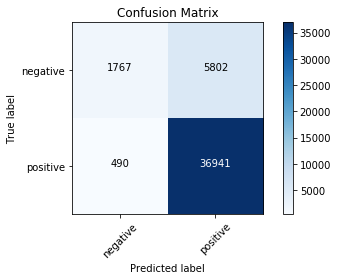


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 36941  |
|           TN (True Negative)           |  1767  |
|          FP (False Positive)           |  5802  |
|          FN (False Negative)           |  490   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.99  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.23  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.77  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.01  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 86.02% |
+----------------------------------------+--------+


Wall time: 14min 53s


In [17]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(randomForestClassifier, 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(tfidf_w2v_train,Y_TRAIN)

print("Best Hyperparameter 'n_estimators' : ",gscv.best_params_.get('n_estimators'))
print("Accuracy on TF-IDF Weighted Word2Vec : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,tfidf_w2v_train,tfidf_w2v_test)

---
### Conclusion :
---

In [18]:
conclude_RF()

+------------------------------------------------------------------------------------------------------+
|                                  *** Conclusion - Random Forest ***                                  |
+--------------+-------------------+-------------------------------+-------------+---------------------+
|      CV      |       Model       | Hyperparameter 'n_estimators' | Train Error |      Test Error     |
+--------------+-------------------+-------------------------------+-------------+---------------------+
| GridSearchCV |       BOW:RF      |              100              |     0.0%    | 14.000000000000002% |
| GridSearchCV |      TFIDF:RF     |              100              |     0.0%    |        13.0%        |
| GridSearchCV |  AVG-WORD2VEC:RF  |              100              |     0.0%    |        13.0%        |
| GridSearchCV | TFIDF-WORD2VEC:RF |              100              |     0.0%    | 14.000000000000002% |
+--------------+-------------------+-------------------

<br/>
<br/>

###  ------------------- Ensemble Model : Boosting ( Gradient Boosting Decision Tree )  -------------------

In [19]:
# Ideal values of n_estimators-More information http://scikit-learn.org/stable/modules/ensemble.html#parameters
parameters = {'max_depth':[1,2,3],
              'learning_rate':[0.0001,0.001,0.01,0.1],
              'n_estimators':[100,300,500,700,900,1100,1300]}

# List of hyperparameters 
list_max_depth = []
list_learning_rate = []
list_n_estimators = []


# Training roc_auc_ score
train_roc_auc_score = []

# Test roc_auc_ score
test_roc_auc_score = []

### (3) Implementation of GBDT :  XGBOOST 


In [20]:
# GridSearchCV with XGBOOST estimator
def perform_gridsearch_cv(estimator,parameters,x_tr,y_tr):
    # Perform cross validation 
    gscv = GridSearchCV(estimator,
                        param_grid = parameters,
                        scoring="roc_auc",
                        cv = TimeSeriesSplit(n_splits=3),
                        n_jobs = -1,
                        verbose = 1)

    # Fit the model
    gscv.fit(x_tr,y_tr)

    optimal_max_depth = gscv.best_params_.get('max_depth')
    list_max_depth.append(optimal_max_depth)

    optimal_learning_rate = gscv.best_params_.get('learning_rate')
    list_learning_rate.append(optimal_learning_rate)

    optimal_n_estimators = gscv.best_params_.get('n_estimators')
    list_n_estimators.append(optimal_n_estimators)

    print() 
    print("Best HyperParameter 'max_depth': ",optimal_max_depth)
    print("Best HyperParameter 'learning_rate': ",optimal_learning_rate)
    print("Best HyperParameter 'n_estimators': ",optimal_n_estimators)
    print("Best ROC_AUC Score on Train Data: ",gscv.best_score_)
    
    return gscv

# Predict values and generate reports
def predict_generate_reports(classifier,gscv,x_tr,x_te,y_tr,y_te):
    predicted_y_train = classifier.predict(x_tr)
    predicted_y_test = classifier.predict(x_te)

    print()          
    ptable = PrettyTable()
    ptable.title = "Classification Report with n_estimators = {0}, max_depth = {1}, learning_rate = {2}".format(gscv.best_params_.get('n_estimators'),
                                                                                                                gscv.best_params_.get('max_depth'),
                                                                                                                gscv.best_params_.get('learning_rate'))
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(y_te, predicted_y_test,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,
                        "{0:.2f}".format(inner_dict['precision']),
                        "{0:.2f}".format(inner_dict['recall']),
                        "{0:.2f}".format(inner_dict['f1-score']),
                        "{0:.2f}".format(inner_dict['support'])])

    print(ptable)   

    train_roc_auc_score.append(roc_auc_score(y_tr,classifier.predict_proba(x_tr)[:,1]))
    
    test_roc_auc_score.append(roc_auc_score(y_te,classifier.predict_proba(x_te)[:,1]))
    
    print()
    print()
    print("--------------- Confusion Matrix of Test Data ---------------")
    sns.set(font_scale=1.4)
    sns.heatmap(pd.DataFrame(confusion_matrix(y_te, predicted_y_test), range(2),range(2)), 
                annot=True,
                annot_kws={"size": 14}, 
                fmt='g') 
    


#### (3.1) Bag of Words (BoW) :

In [21]:
# Instantiate XGBoost
xgbClassifier = XGBClassifier(n_jobs= 6)
xgbClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
%%time

# Instantiate CountVectorizer
bow_count_vectorizer = CountVectorizer()

# Tokenize and build vocab
bow_count_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = bow_count_vectorizer.transform(X_TRAIN)
x_test_matrix = bow_count_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (105000, 46035)
The number of unique words in train matrix  46035
Wall time: 6.5 s


In [23]:
%%time
# Perform GridSearchCV
gscv = perform_gridsearch_cv(xgbClassifier,parameters,x_train_matrix,Y_TRAIN)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 30.5min finished



Best HyperParameter 'max_depth':  3
Best HyperParameter 'learning_rate':  0.1
Best HyperParameter 'n_estimators':  1300
Best ROC_AUC Score on Train Data:  0.9328530517869714
Wall time: 31min 10s


In [24]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_
classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1300,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


+--------------------------------------------------------------------------------------+
|  Classification Report with n_estimators = 1300, max_depth = 3, learning_rate = 0.1  |
+------------------------------+---------------+-----------+-------------+-------------+
|     Class Lable/Averages     |   Precision   |   Recall  |   F1-Score  |   Support   |
+------------------------------+---------------+-----------+-------------+-------------+
|           negative           |      0.85     |    0.55   |     0.67    |   7569.00   |
|           positive           |      0.92     |    0.98   |     0.95    |   37431.00  |
|          micro avg           |      0.91     |    0.91   |     0.91    |   45000.00  |
|          macro avg           |      0.88     |    0.77   |     0.81    |   45000.00  |
|         weighted avg         |      0.91     |    0.91   |     0.90    |   45000.00  |
+------------------------------+---------------+-----------+-------------+-------------+


--------------- Co

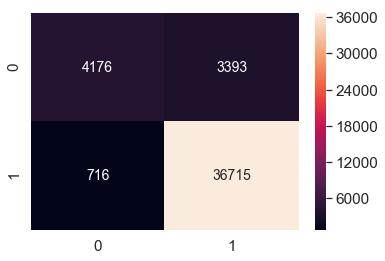



ROC-AUC Score on Test Data:  0.9411684840574354


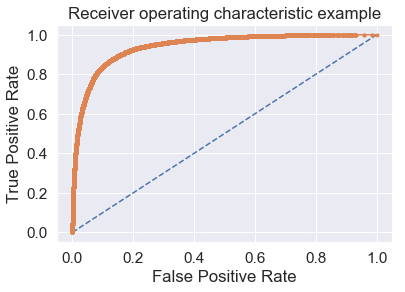

In [25]:
# Predict and generate reports
predict_generate_reports(classifier,gscv,x_train_matrix,x_test_matrix,Y_TRAIN,Y_TEST)
plt.show()

print()
print()
print("ROC-AUC Score on Test Data: ",test_roc_auc_score[-1])
plt.figure()
fpr, tpr, threshold = roc_curve(Y_TEST,classifier.predict_proba(x_test_matrix)[:,1],pos_label="positive")
plt.title('Receiver operating characteristic example')
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker=".")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print()
print()

#### (3.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [26]:
%%time

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)
x_test_matrix = tfidf_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (105000, 239302)
The number of unique words in train matrix  239302
Wall time: 19 s


In [30]:
%%time

# Perform GridSearchCV
gscv = perform_gridsearch_cv(xgbClassifier,parameters,x_train_matrix,Y_TRAIN)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 92.0min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 124.9min finished



Best HyperParameter 'max_depth':  3
Best HyperParameter 'learning_rate':  0.1
Best HyperParameter 'n_estimators':  1300
Best ROC_AUC Score on Train Data:  0.9390933137456682
Wall time: 2h 7min 20s


In [31]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_
classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1300,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


+--------------------------------------------------------------------------------------+
|  Classification Report with n_estimators = 1300, max_depth = 3, learning_rate = 0.1  |
+------------------------------+---------------+-----------+-------------+-------------+
|     Class Lable/Averages     |   Precision   |   Recall  |   F1-Score  |   Support   |
+------------------------------+---------------+-----------+-------------+-------------+
|           negative           |      0.88     |    0.58   |     0.70    |   7569.00   |
|           positive           |      0.92     |    0.98   |     0.95    |   37431.00  |
|          micro avg           |      0.92     |    0.92   |     0.92    |   45000.00  |
|          macro avg           |      0.90     |    0.78   |     0.83    |   45000.00  |
|         weighted avg         |      0.91     |    0.92   |     0.91    |   45000.00  |
+------------------------------+---------------+-----------+-------------+-------------+


--------------- Co

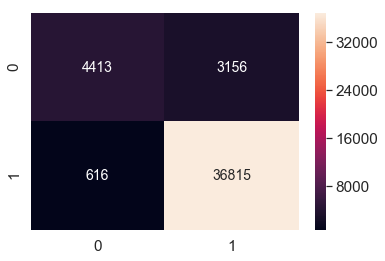

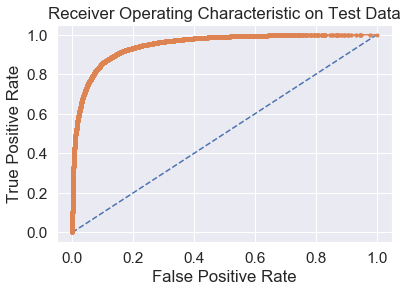

In [32]:
# Predict and generate reports
predict_generate_reports(classifier,gscv,x_train_matrix,x_test_matrix,Y_TRAIN,Y_TEST)

print()
print()
print("ROC-AUC Score on Test Data: ",test_roc_auc_score[-1])
plt.figure()
fpr, tpr, threshold = roc_curve(Y_TEST,classifier.predict_proba(x_test_matrix)[:,1],pos_label="positive")
plt.title('Receiver Operating Characteristic on Test Data')
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker=".")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print()
print()


#### (3.3) Average Word2Vec :

In [33]:
%%time

# Create our own Word2Vec model from training data.
        
# Make list of list from training data
list_of_sentences_in_train=[]
for sentence in X_TRAIN:
    list_of_sentences_in_train.append(sentence.split())
            
# Make list of list from testing data - this will be useful when vectorizing testing data.
list_of_sentences_in_test=[]
for sentence in X_TEST:
    list_of_sentences_in_test.append(sentence.split())
            
print("Shape of training data : ",X_TRAIN.shape)
print("Shape of testing data : ",X_TEST.shape)
print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
        
# Generate model
w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=200, workers=6)
        
# List of word in vocabulary 
w2v_words = list(w2v_model.wv.vocab)
print("Length of vocabulary : ",len(w2v_words))

# Prepare train vectorizer using trained word2vec model
train_list = []
for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
    word_2_vec = np.zeros(200)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    train_list.append(word_2_vec)
        
# Prepare test vectorizer using trained word2vec model
test_list = []
for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
    word_2_vec = np.zeros(200)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    test_list.append(word_2_vec)
            
avg_w2v_train = np.array(train_list)
avg_w2v_test = np.array(test_list)
           

print("\nShape of training vectorizer : ",avg_w2v_train.shape)
print("Shape of testing vectorizer : ",avg_w2v_test.shape)

Shape of training data :  (105000,)
Shape of testing data :  (45000,)
Number of sentences present in training data :  105000
Number of sentences present in testing data :  45000
Length of vocabulary :  16602


Average Word2Vec - Test data: 100%|█████████████████████████████████████| 45000/45000 [00:44<00:00, 1006.63 sentence/s]



Shape of training vectorizer :  (105000, 200)
Shape of testing vectorizer :  (45000, 200)
Wall time: 2min 33s


In [34]:
%%time

# Perform GridSearchCV
gscv = perform_gridsearch_cv(xgbClassifier,parameters,avg_w2v_train,Y_TRAIN)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 140.9min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 193.5min finished



Best HyperParameter 'max_depth':  2
Best HyperParameter 'learning_rate':  0.1
Best HyperParameter 'n_estimators':  1300
Best ROC_AUC Score on Train Data:  0.9219202802535383
Wall time: 3h 16min 24s


In [35]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_
classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1300,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


+--------------------------------------------------------------------------------------+
|  Classification Report with n_estimators = 1300, max_depth = 2, learning_rate = 0.1  |
+------------------------------+---------------+-----------+-------------+-------------+
|     Class Lable/Averages     |   Precision   |   Recall  |   F1-Score  |   Support   |
+------------------------------+---------------+-----------+-------------+-------------+
|           negative           |      0.79     |    0.55   |     0.65    |   7569.00   |
|           positive           |      0.91     |    0.97   |     0.94    |   37431.00  |
|          micro avg           |      0.90     |    0.90   |     0.90    |   45000.00  |
|          macro avg           |      0.85     |    0.76   |     0.80    |   45000.00  |
|         weighted avg         |      0.89     |    0.90   |     0.89    |   45000.00  |
+------------------------------+---------------+-----------+-------------+-------------+


--------------- Co

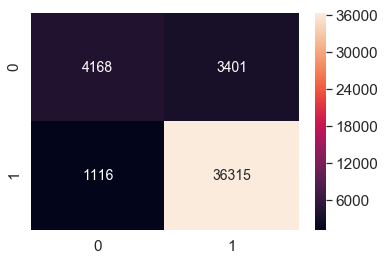

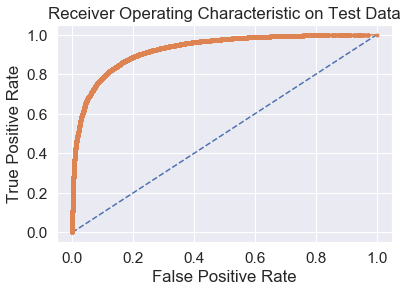

In [36]:
# Predict and generate reports
predict_generate_reports(classifier,gscv,avg_w2v_train,avg_w2v_test,Y_TRAIN,Y_TEST)

print()
print()
print("ROC-AUC Score on Test Data: ",test_roc_auc_score[-1])
plt.figure()
fpr, tpr, threshold = roc_curve(Y_TEST,classifier.predict_proba(avg_w2v_test)[:,1],pos_label="positive")
plt.title('Receiver Operating Characteristic on Test Data')
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker=".")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print()
print()

#### (3.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [37]:
%%time

# Make list of list from training data.      
sentences_in_train=[]
for sentence in X_TRAIN:
    sentences_in_train.append(sentence.split())

# Make list of list from testing data - this will be useful when vectorizing testing data.
sentences_in_test=[]
for sentence in X_TEST:
    sentences_in_test.append(sentence.split())
            
# Generate model
w2v_model = Word2Vec(sentences_in_train,min_count=3,size=200, workers=6)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

# Dictionary with word as a key, and the idf as a value
dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))

# Prepare train vectorizer using trained word2vec model        
train_list = []
row = 0
for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
    word_2_vec = np.zeros(200)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    train_list.append(word_2_vec)
    row += 1
        
# Prepare test vectorizer using trained word2vec model
test_list = []
row = 0
for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
    word_2_vec = np.zeros(200)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    test_list.append(word_2_vec)
    row += 1
        
tfidf_w2v_train = np.array(train_list)
tfidf_w2v_test = np.array(test_list)


print("\nShape of training vectorizer : ",tfidf_w2v_train.shape)
print("Shape of testing vectorizer : ",tfidf_w2v_test.shape)

TF-IDF Weighted Word2Vec - Test data: 100%|█████████████████████████████| 45000/45000 [00:13<00:00, 3307.56 sentence/s]



Shape of training vectorizer :  (105000, 200)
Shape of testing vectorizer :  (45000, 200)
Wall time: 1min 10s


In [38]:
%%time

# Perform GridSearchCV
gscv = perform_gridsearch_cv(xgbClassifier,parameters,tfidf_w2v_train,Y_TRAIN)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 140.8min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 194.3min finished



Best HyperParameter 'max_depth':  3
Best HyperParameter 'learning_rate':  0.1
Best HyperParameter 'n_estimators':  1100
Best ROC_AUC Score on Train Data:  0.9016922392605504
Wall time: 3h 17min 56s


In [39]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_
classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1100,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


+--------------------------------------------------------------------------------------+
|  Classification Report with n_estimators = 1100, max_depth = 3, learning_rate = 0.1  |
+------------------------------+---------------+-----------+-------------+-------------+
|     Class Lable/Averages     |   Precision   |   Recall  |   F1-Score  |   Support   |
+------------------------------+---------------+-----------+-------------+-------------+
|           negative           |      0.77     |    0.50   |     0.60    |   7569.00   |
|           positive           |      0.90     |    0.97   |     0.94    |   37431.00  |
|          micro avg           |      0.89     |    0.89   |     0.89    |   45000.00  |
|          macro avg           |      0.84     |    0.73   |     0.77    |   45000.00  |
|         weighted avg         |      0.88     |    0.89   |     0.88    |   45000.00  |
+------------------------------+---------------+-----------+-------------+-------------+


--------------- Co

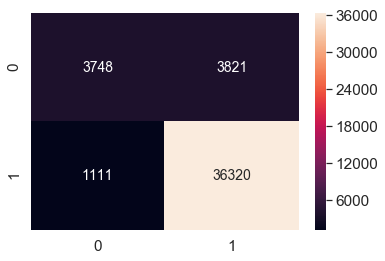

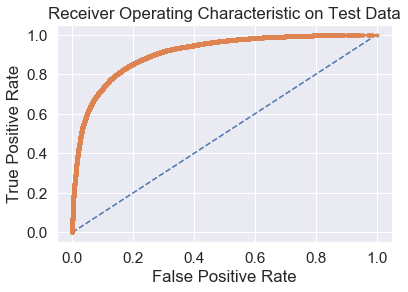

In [40]:
# Predict and generate reports
predict_generate_reports(classifier,gscv,tfidf_w2v_train,tfidf_w2v_test,Y_TRAIN,Y_TEST)

print()
print()
print("ROC-AUC Score on Test Data: ",test_roc_auc_score[-1])
plt.figure()
fpr, tpr, threshold = roc_curve(Y_TEST,classifier.predict_proba(tfidf_w2v_test)[:,1],pos_label="positive")
plt.title('Receiver Operating Characteristic on Test Data')
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr,marker=".")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print()
print()

---
### Conclusion :
---

In [44]:
conclude_GBDT()

+--------------------------------------------------------------------------------------------------------------+
|                                      *** Conclusion - GBDT(XGBOOST) ***                                      |
+------------------------+--------------+---------------+-----------+---------------------+--------------------+
|         Model          | n_estimators | learning_rate | max_depth | Train ROC-AUC Score | Test ROC-AUC Score |
+------------------------+--------------+---------------+-----------+---------------------+--------------------+
|      BOW:XGBOOST       |     1300     |      0.1      |     3     |  0.9633664513720004 | 0.9411684840574354 |
|     TFIDF:XGBOOST      |     1300     |      0.1      |     3     |  0.9723346178608838 | 0.9493089621628152 |
|  AVG-WORD2VEC:XGBOOST  |     1300     |      0.1      |     2     |  0.9484731745096541 | 0.9268064009786638 |
| TFIDF-WORD2VEC:XGBOOST |     1100     |      0.1      |     3     |  0.9571633732409064 | 0.90

---
### Observations :
---

> 1. Here, Random Forest and Gradient Boosting Decision Tree is applied on amazon fine food review dataset with time series splitting(~150K).
> 2. Given dataset is imbalanced in nature (postive reviews:negative reviews = 5.57/1).
> 3. Grid search cross validation with 2/3-fold technique is applied to calculate optimal hyperparameters like max_depth,n_estimators etc.
> 4. Random forest produces almost similar result for each vatorization.Accuracy scoring is used as a performance measure.
> 5. Whereas in XGBOOST,implementation of GBDT, we have used auc score as a performance measure. 
> 6. XGBOOST produces excellent results(which is above~0.9) for all vectorizers.
> 7. for more information you can always refer to conclusion table above.